# Libraires

In [1]:
# import json file called config
import json
with open('config.json') as f:
    config = json.load(f)
TOKENIZER_ID = config['TOKENIZER_ID']

nrows = None if config['nrows'] == 0 else config['nrows']

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import PassiveAggressiveClassifier #used to train the model
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, confusion_matrix, roc_auc_score, roc_curve # this is used to evaluate the model.
from sklearn.model_selection import train_test_split # to separate the dataset.
from sklearn.feature_extraction.text import TfidfVectorizer #used for the transformation of text data.
import pickle as pkl #file to save and load a model.
from sklearn.model_selection import GridSearchCV #pour l'optimisation des hyperparametres.
import time #pour étudier le temps d'execution d'entrainement, de notre meilleure modèle.
import psutil #pour calculer la mémoire.
import os #pour calculer le temps d'execution.
import joblib


# Load Data

In [3]:
data=pd.read_csv('title_text.csv',nrows=nrows)
#check if isFake column has unique values
print(data['isFake'].value_counts())

True     21417
False    21417
Name: isFake, dtype: int64


In [4]:
data

,Unnamed: 0,title,text,isFake
0,0,Leave It To Sesame Street To Teach America Wh...,For everyone other than maybe his investment p...,True
1,1,Bulgarian court sentences three Syrians on ter...,SOFIA (Reuters) - A Bulgarian court on Thursda...,False
2,2,"Rejuvenated Berlusconi lays out vote platform,...",ROME (Reuters) - Former Prime Minister Silvio ...,False
3,3,Pastor Shot And Killed In The Middle Of Churc...,A routine church service at the St. Peter s Mi...,True
4,4,Kushner Is Now Under Fire By Special Counsel ...,The Trump White House is now officially in ful...,True
...,...,...,...,...
42829,42829,Conservative firebrand defeats Trump pick in A...,(Reuters) - Alabama voters elected conservativ...,False
42830,42830,Trump’s GOP Mega Donors Are Demanding A Full ...,Now that Donald Trump has shot himself in the ...,True
42831,42831,4 Yr Old Stoned By Muslim Migrant For Kicking ...,The old reliable stone most commonly used by a...,True
42832,42832,Kasich calls for 'active steps' to strengthen ...,WASHINGTON (Reuters) - Presidential candidate ...,False


In [5]:
#we make everything lower.
data['text']=data['text'].apply(lambda x: x.lower())
data

,Unnamed: 0,title,text,isFake
0,0,Leave It To Sesame Street To Teach America Wh...,for everyone other than maybe his investment p...,True
1,1,Bulgarian court sentences three Syrians on ter...,sofia (reuters) - a bulgarian court on thursda...,False
2,2,"Rejuvenated Berlusconi lays out vote platform,...",rome (reuters) - former prime minister silvio ...,False
3,3,Pastor Shot And Killed In The Middle Of Churc...,a routine church service at the st. peter s mi...,True
4,4,Kushner Is Now Under Fire By Special Counsel ...,the trump white house is now officially in ful...,True
...,...,...,...,...
42829,42829,Conservative firebrand defeats Trump pick in A...,(reuters) - alabama voters elected conservativ...,False
42830,42830,Trump’s GOP Mega Donors Are Demanding A Full ...,now that donald trump has shot himself in the ...,True
42831,42831,4 Yr Old Stoned By Muslim Migrant For Kicking ...,the old reliable stone most commonly used by a...,True
42832,42832,Kasich calls for 'active steps' to strengthen ...,washington (reuters) - presidential candidate ...,False


# Modification du text en données numériques.
Nous partons du principe que les données ont étés clean et que nous pouvons nous concerntrer à créer un model.

Comme les informations principales pour définir des Fake news et des vrai news, se base sur le texte et le titre, nous devons nous focaliser sur ces informations. Il faut ainsi que nous transformons le text et le titre en données afin que notre model puisse utiliser des données numériques pour trouver la bonne réponse. Nous allons utiliser la methode de bert-.
# Bert tokenizer

In [6]:
from transformers import BertTokenizer, BertModel


X = data['text']

# Create the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model_bert = BertModel.from_pretrained('bert-base-uncased')

# Set the maximum sequence length
max_seq_length = 512

# Truncate or pad the tokenized sequences
X = X.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_seq_length, truncation=True, padding='max_length'))
print(X)

0        [101, 2005, 3071, 2060, 2084, 2672, 2010, 5211...
1        [101, 8755, 1006, 26665, 1007, 1011, 1037, 764...
2        [101, 4199, 1006, 26665, 1007, 1011, 2280, 353...
3        [101, 1037, 9410, 2277, 2326, 2012, 1996, 2358...
4        [101, 1996, 8398, 2317, 2160, 2003, 2085, 3985...
                               ...                        
42829    [101, 1006, 26665, 1007, 1011, 6041, 7206, 270...
42830    [101, 2085, 2008, 6221, 8398, 2038, 2915, 2370...
42831    [101, 1996, 2214, 10539, 2962, 2087, 4141, 210...
42832    [101, 2899, 1006, 26665, 1007, 1011, 4883, 401...
42833    [101, 2899, 1006, 26665, 1007, 1011, 1057, 101...
Name: text, Length: 42834, dtype: object


In [7]:
y = data['isFake'].astype(int) #make it numerical
print(y.value_counts())

1    21417
0    21417
Name: isFake, dtype: int64


In [8]:
# we separate the trdata into training test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
import numpy as np

In [10]:
X_train = np.array(X_train.tolist())
y_train= np.array(y_train.tolist())
X_train.shape,y_train.shape

((27413, 512), (27413,))

In [11]:
X_test = np.array(X_test.tolist())
y_test= np.array(y_test.tolist())
X_test.shape,y_test.shape

((8567, 512), (8567,))

# Model Passive Agressive

Quand on parle d'un model passive aggressive, nous parlons d'un algorithme linéaire de classification et de regression. C'est un algorithme d'apprentissage en ligne, Il traite les données séquentiellement, ajustant le prédicteur à chaque nouvelle instance pour améliorer la prédiction future.

Le modèle se base sur deux principes:
- **Passive**: Si notre modèle prédit une instance juste, alors les poids et les biais ne seront pas changés. L'état actuelle de notre modèle sera maintenu.
- **Aggressive**: Si notre modèle fait une mauvaise prédiction sur une instance ressus, les poids et biais de notre modèle seront changés par le paramètre de régularisation **C**, le but étant de minimiser l'erreur. Il change les paramètres pour que la prédiction actuelle soit 'just'.

Le modèle utilise par défaut la fonction de cout **hinge**. Voici comment mathématiquement les poids et bias seront changés:

$$ w_{\text{new}} = w + \alpha y x $$
$$ b_{\text{new}} = b + \alpha y $$

où **w** est le vecteur de poids, **b** est le biais, **x** est le vecteur de caractéristiques de l'instance mal classée, **y** est l'étiquette correcte de l'instance, et **α** est le taux d'apprentissage calculé en fonction de l'erreur et du paramètre de régularisation **C**

Comme nous traitons des données de texte, et que nous devons faire une classification binaire, il ce va de dire que les text vont avoir des pattern differents, en utilisant le model passive aggressive, nous pouvons entrainer le model à définir une méthode pour les idenfifier.

In [12]:
# we build our model: C is the regulation parameter, and denotes the penalization the model will make on an incorrect prediciton.
model = PassiveAggressiveClassifier(C = 0.2, 
                                    random_state = 42,
                                    early_stopping=True,# we enable the early stopping procedure.
                                    n_iter_no_change=3, #number of iterations before early stopping
                                    verbose=True,
                                    loss='hinge', #fonction de cout
                                   )


In [13]:
#on entraine le model sur les données d'entrainement.
model.fit(X_train,y_train)
#Create or open a file with write-binary mode and save the model to it

-- Epoch 1
Norm: 0.01, NNZs: 512, Bias: 0.000098, T: 24671, Avg. loss: 1.880353
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 0.01, NNZs: 512, Bias: 0.000098, T: 49342, Avg. loss: 0.755435
Total training time: 0.13 seconds.
-- Epoch 3
Norm: 0.01, NNZs: 512, Bias: 0.000098, T: 74013, Avg. loss: 0.692524
Total training time: 0.20 seconds.
-- Epoch 4
Norm: 0.01, NNZs: 512, Bias: 0.000099, T: 98684, Avg. loss: 0.974523
Total training time: 0.28 seconds.
-- Epoch 5
Norm: 0.01, NNZs: 512, Bias: 0.000099, T: 123355, Avg. loss: 0.635960
Total training time: 0.36 seconds.
Convergence after 5 epochs took 0.39 seconds


PassiveAggressiveClassifier(C=0.2, early_stopping=True, n_iter_no_change=3,
                            random_state=42, verbose=True)

In [14]:
#on sort les predictions
#Step 2: Open the saved file with read-binary mode
y_pred=model.predict(X_test)
y_pred.shape

(8567,)

# Optimisation

Pour optimiser le model nous allons modifier les paramètres suivants:
- **C (Le paramètre de régularisation)**: Un des paramètres les plus importants de l'algorithme passive aggressive. Il est utilisé pour controler la marge d'erreur que notre modèle est près à accepté. Si on lui donne une valeur de plus en plus élevé il se peut que le modèle suraprenne, car il s'adapte mieux aux données d'entrainement. Ainsi une valeur plus faible serait favorable. Nous allons tester C avec les valeurs suivantes: **[0.01,0.05,0.1,0.5,1]**

In [15]:
params_grid={'C':[0.01,0.05,0.1,0.5,1]}

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import make_scorer, accuracy_score


# Initialize the Passive Aggressive Classifier
model = PassiveAggressiveClassifier(random_state=42,early_stopping=True)

# On creer un scorer pour le grid search 
scorer = make_scorer(accuracy_score)

# Initialisation de la GridSearch pour trouver le meilleur C.
grid_search = GridSearchCV(estimator=model, param_grid=params_grid, scoring=scorer, cv=5)

# On lance les multiples entrainements.
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=PassiveAggressiveClassifier(early_stopping=True,
                                                   random_state=42),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1]},
             scoring=make_scorer(accuracy_score))

In [17]:
# Get the best combination of parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")


Best parameters: {'C': 0.01}
Best score: 0.707112229016316


# Model Evaluation

Afin d'évaluer le modèle nous faisons une représentation graphique des résultats obtenus. Nous allons étudier les metrics suivants:
- le **temps d'entrainement** que le modèle a besoin, ainsi que son **taux de mémoire (Mo)**.
- **matrice de confusion**, qui est un excellent choix d'évaluation de performance, car nous sommes dans le cas d'une classification binaire. 
- **L'accuracy** du model.
- **La précision**
- **recall**
- **F1-score**.
- **ROC-AUC score**

src: https://www.v7labs.com/blog/performance-metrics-in-machine-learning#h2

In [18]:
#creation du modèle avec les meilleurs paramètres
best_model=PassiveAggressiveClassifier(C=best_params['C'],
                                       early_stopping=True,
                                       verbose=True,
                                       random_state=42)

Nous voullons étudier **le temps d'entrainement (en h/m/s)** et **l'utilisation de la mémoire (Mo)** que le modèle a besoin.

In [19]:
def second_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return int(hours), int(minutes), int(seconds)

def bytes_to_Mo(mem_bytes):
    mem_kb = mem_bytes / 1024  # Convertir en kilooctets
    mem_mb = mem_kb / 1024  # Convertir en mégaoctets
    return mem_mb

In [20]:
#lancemenet de l'enrestristrement de la mémoire.
process = psutil.Process(os.getpid())
mem_before_bytes = process.memory_info().rss

#lancement de l'enregistrement du temps d'entrainement.
start_time = time.time() 
# entrainement du modèle.
best_model.fit(X_train,y_train)
end_time = time.time()

#le temps écoulé 
elapsed_time= end_time - start_time

print(f"Temps d'entrainement (h | m | s) : {second_to_hms(elapsed_time)[0]} | {second_to_hms(elapsed_time)[1]} | {second_to_hms(elapsed_time)[2]}")

mem_after_bytes = process.memory_info().rss
#on convertit les bytes en Mo.
mem_bytes=mem_after_bytes - mem_before_bytes


print(f"Utilisation de la mémoire (Mo) : {bytes_to_Mo(mem_bytes)}")

-- Epoch 1
Norm: 0.01, NNZs: 512, Bias: 0.000098, T: 24671, Avg. loss: 1.880353
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 0.01, NNZs: 512, Bias: 0.000098, T: 49342, Avg. loss: 0.755435
Total training time: 0.13 seconds.
-- Epoch 3
Norm: 0.01, NNZs: 512, Bias: 0.000098, T: 74013, Avg. loss: 0.692524
Total training time: 0.21 seconds.
-- Epoch 4
Norm: 0.01, NNZs: 512, Bias: 0.000099, T: 98684, Avg. loss: 0.974523
Total training time: 0.29 seconds.
-- Epoch 5
Norm: 0.01, NNZs: 512, Bias: 0.000099, T: 123355, Avg. loss: 0.635960
Total training time: 0.37 seconds.
-- Epoch 6
Norm: 0.01, NNZs: 512, Bias: 0.000098, T: 148026, Avg. loss: 1.498579
Total training time: 0.44 seconds.
-- Epoch 7
Norm: 0.01, NNZs: 512, Bias: 0.000098, T: 172697, Avg. loss: 1.255906
Total training time: 0.52 seconds.
Convergence after 7 epochs took 0.55 seconds
Temps d'entrainement (h | m | s) : 0 | 0 | 0
Utilisation de la mémoire (Mo) : 0.0


In [21]:
#optention des prédictions de ce modèle.
y_pred=best_model.predict(X_test)
y_pred.shape,y_test.shape

((8567,), (8567,))

Nous déterminons la **matrice de confusion**.

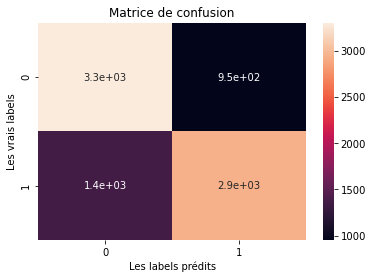

In [22]:
#creation de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

#représentation graphique du résultat du meilleure model
sns.heatmap(cm, annot=True)
plt.xlabel('Les labels prédits')
plt.ylabel('Les vrais labels')
plt.title('Matrice de confusion')
plt.show()

In [23]:
print(f"le modèle a donc {cm[0][0]} instances vrai Positives et {cm[1][1]} instances de Vrai négatives, {cm[1][0]} instances de Faux Positives et {cm[0][1]} instances de Faux négatives. ")

le modèle a donc 3303 instances vrai Positives et 2945 instances de Vrai négatives, 1370 instances de Faux Positives et 949 instances de Faux négatives. 


Nous allons avant tout calculer **la précision globale (accuracy)** de notre modèle. 

In [24]:
acc=accuracy_score(y_pred,y_test)
print(f"Notre modèle a une précision globale de {round(acc*100,2)}%, ce qui signifie qu'il prédit correctement les classes des instances dans {round(acc*100,2)}% des cas.")

Notre modèle a une précision globale de 72.93%, ce qui signifie qu'il prédit correctement les classes des instances dans 72.93% des cas.


on calcul le **precision**, c'est la capacité du modèle à correctement identifier les instances que nous avons prédits. Donc de prédire qu'une News vrai soit vraie.

In [25]:
precision=precision_score(y_test,y_pred)
print(f"notre model a une precision de {round(precision*100,2)}% . lorsqu'il prédit une classe comme positive, il a raison dans {round(precision*100,2)}% des cas.")

notre model a une precision de 75.63% . lorsqu'il prédit une classe comme positive, il a raison dans 75.63% des cas.


on calcul le **recall**, ce qui es le pourcentage de Vrai positif **(dans notre cas les Vrai news)** que notre modèle arrive à prédire.

In [26]:
recall=recall_score(y_test,y_pred)
print(f"notre model arrive a détecter {round(recall*100,2)}%. Donc sur l'ensemble des vrai positives, le modèle parvient à en identifier correctement {round(recall*100,2)}% des cas.")

notre model arrive a détecter 68.25%. Donc sur l'ensemble des vrai positives, le modèle parvient à en identifier correctement 68.25% des cas.


On calcule le **F1-score**, c'est une combinaison de la précision et du recall, en calculant la moyenne harmonique entre les deux. Son but est **d'étudier l'équilibre entre la precision et le recall.**

In [27]:
f1score=f1_score(y_test,y_pred)
print(f"notre model a un F1-score de {round(f1score*100,2)}%, ce qui signifie que il y a un excellent equilibre entre le recall et la précision.")

notre model a un F1-score de 71.75%, ce qui signifie que il y a un excellent equilibre entre le recall et la précision.


## Courbe ROC-AUC
Dans le contexte d'une classification binaire, il est essentiel d'utiliser la courbe ROC-AUC pour évaluer notre modèle. Nous allons examiner deux aspects :

- **ROC (Receiver Operating Characteristic)**: Cette courbe illustre le rapport entre le taux de vrais positifs et le taux de faux positifs. Elle permet de visualiser la capacité du modèle à discriminer entre les deux classes.

- **AUC (Area Under the Curve)**: C'est une mesure qui résume la courbe ROC en calculant l'aire sous celle-ci et au-dessus de la diagonale qui va du coin inférieur gauche au coin supérieur droit du graphique. Un score AUC proche de 1 indique que notre modèle fait des prédictions presque parfaites. En revanche, un score proche de 0,5 suggère que nos prédictions sont principalement due au hasard, ce qui signifie que le modèle n'apprend pas de manière efficace.

L'objectif de ces mesures est de déterminer à quel point notre modèle est efficace dans la tâche de classification binaire.

On définit le score ROC-AUC.

In [28]:
roc_auc=roc_auc_score(y_test,y_pred)
roc_auc

0.729656904691569

In [29]:
print(f"Le modèle a donc une score ROC-AUC de {roc_auc} ce qui est très proche de 1, donc le modèle a une excellente capacité à différencier entres les Fake et les vrais news.")

Le modèle a donc une score ROC-AUC de 0.729656904691569 ce qui est très proche de 1, donc le modèle a une excellente capacité à différencier entres les Fake et les vrais news.


Avec une valeur aussi élevée, nous pouvons être confiants dans le fait que notre modèle est extrêmement précis et fiable pour notre tâche de classification, avec très peu de faux positifs et de faux négatifs. Cela indique que notre modèle fait des erreurs de prédiction minimales. Nous allons maintenant procéder à la représentation graphique de la courbe ROC-AUC.

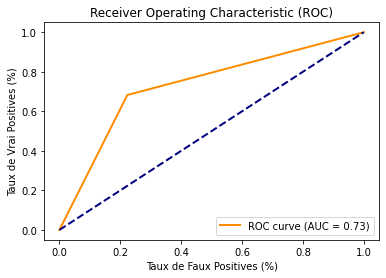

In [30]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de Faux Positives (%)')
plt.ylabel('Taux de Vrai Positives (%)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

L'axe des abscisses (axe x) représente le taux de faux positifs, c'est-à-dire le pourcentage de vraies nouvelles que notre modèle a incorrectement classifiées comme fausses (Fake News).

L'axe des ordonnées (axe y) indique le taux de vrais positifs, qui correspond au pourcentage de fausses nouvelles que notre modèle a correctement identifiées comme telles.

La courbe montante vers le coin supérieur gauche du graphique suggère que le modèle parvient à maintenir un taux élevé de vrais positifs tout en minimisant le taux de faux positifs, ce qui est le comportement idéal pour un classificateur. 
Cette représentation représente la robustesse du mdoèle.

# Test de performances sur des données générées par Téléchargé ailleurs

In [31]:
validation_data=pd.read_csv("data/validation_data.csv")
validation_data.head()

,Unnamed: 0,text,isFake
0,0,"Daniel Greenfield, a Shillman Journalism Fello...",False
1,1,Google Pinterest Digg Linkedin Reddit Stumbleu...,False
2,2,U.S. Secretary of State John F. Kerry said Mon...,True
3,3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",False
4,4,It's primary day in New York and front-runners...,True


In [32]:
validation_data=validation_data[['text','isFake']]
validation_data

,text,isFake
0,"Daniel Greenfield, a Shillman Journalism Fello...",False
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,False
2,U.S. Secretary of State John F. Kerry said Mon...,True
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",False
4,It's primary day in New York and front-runners...,True
...,...,...
6330,The State Department told the Republican Natio...,True
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,False
6332,Anti-Trump Protesters Are Tools of the Oligar...,False
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",True


In [33]:
# Prepare the data
validation_data_X = validation_data['text'].apply(lambda x: x.lower())  # the text data
validation_data_y = validation_data['isFake']

# Tokenize the data using the BERT tokenizer
encoded_inputs = tokenizer(validation_data_X.tolist(), padding=True, truncation=True, max_length=max_seq_length, return_tensors='np')

# Get the input IDs and attention masks
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

# Use the trained model to make predictions on the dataset
predictions = best_model.predict(input_ids)


In [34]:
confusion_matrix(validation_data_y,predictions)

array([[1176, 1988],
       [ 928, 2243]], dtype=int64)

In [35]:
accuracy_score(validation_data_y,predictions)

0.5397000789265982

# Conclusion

les évaluations et analyses approfondies de notre modèle confirment qu'il est extrêmement efficace et fiable pour l'identification des fake news. Ses performances élevées sur plusieurs métriques clés (accuracy,precision,recall,F1-score et ROC-AUC) démontrent sa capacité à fournir des prédictions précises et équilibrées, confortant notre choix d'utiliser ce modèle pour cette tache.